In [1]:
import new_analysis
import pandas as pd
import root_pandas as rp
import numpy as np
import matplotlib.pyplot as plt
import ROOT
import array
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.lines import Line2D
from matplotlib import rc
rc('text', usetex=True)

Welcome to JupyROOT 6.16/00


/home/jeef/anaconda3/envs/root_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  means[col]=0 #will be deleted at the end. Used so we can append rows of means
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be

In [2]:
a = new_analysis.analysis()

/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  means[col]=0 #will be deleted at the end. Used so we can append rows of means
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errs[col] = 0
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [3]:
data = a.get_raw_study_data()
data.columns
avg1 = a.compute_means_and_errs('LER', 'Cont_inj', 5)
avg2 = a.compute_means_and_errs('LER', 'Decay', 5)
avg3 = a.compute_means_and_errs('HER', 'Cont_inj', 5)
avg4 = a.compute_means_and_errs('HER', 'Decay', 5)
data_avg = avg1.append([avg2,avg3,avg4])
data_avg.index = [i for i in range(0,len(data_avg))]
data_avg['ts_err']= data_avg['ts_err']/3600
data_avg['ts']=(data_avg['ts']-data['ts'].iloc[0])/3600
data['ts']=(data['ts']-data['ts'].iloc[0])/3600

/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  means[col]=0 #will be deleted at the end. Used so we can append rows of means
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errs[col] = 0
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [4]:
data_avg.keys()

Index(['ts', 'I_HER', 'I_LER', 'P_HER', 'P_LER', 'Sy_HER', 'Sy_LER',
       'ECL_lumi', 'LER_study_flag', 'HER_study_flag', 'Lumi_study_flag',
       'Cont_inj_flag', 'Decay_flag', 'Nb_HER', 'Nb_LER', 'tako_neutrons',
       'palila_neutrons', 'elepaio_neutrons', 'iiwi_neutrons', 'nene_neutrons',
       'humu_neutrons', 'ts_err', 'I_HER_err', 'I_LER_err', 'P_HER_err',
       'P_LER_err', 'Sy_HER_err', 'Sy_LER_err', 'ECL_lumi_err',
       'tako_neutrons_err', 'palila_neutrons_err', 'elepaio_neutrons_err',
       'iiwi_neutrons_err', 'nene_neutrons_err', 'humu_neutrons_err'],
      dtype='object')

In [5]:
bins = 5
study_types = ['LER', 'HER']
study_periods = ["Cont_inj", "Decay"]
tpcs = ['iiwi', 'nene', 'humu', 'palila', 'tako', 'elepaio']
fit_params = {}
fit_bg  = {}
fit_bg_err = {}
fit_t = {}
fit_t_err = {}
fit = {}
fit_err = {}
for study_type in study_types:
    for study_period in study_periods:
        fit_params[study_period + '_' + study_type] = a.get_fit_parameters(study_type, study_period, bins)
        for tpc in tpcs:
            fit_bg[tpc+'_'+study_period+'_'+ study_type] = fit_params[study_period + '_' + study_type][tpc+'_B0']*data_avg['I_%s'%(study_type)] + fit_params[study_period + '_' + study_type][tpc+'_B1']*data_avg['I_%s'%(study_type)]**2
            fit_bg_err[tpc+'_'+study_period+ '_'+study_type] = np.sqrt((fit_params[study_period + '_' + study_type][tpc+'_B0_err']*data_avg['I_%s'%(study_type)])**2 + (fit_params[study_period + '_' + study_type][tpc+'_B1_err']*data_avg['I_%s'%(study_type)]**2)**2)
            fit_t[tpc+'_'+study_period+'_'+ study_type] = fit_params[study_period + '_' + study_type][tpc+'_T']*data_avg['I_%s'%(study_type)]**2/(data_avg['Sy_%s'%(study_type)]*data_avg['Nb_%s'%(study_type)])
            fit_t_err[tpc+'_'+study_period+'_'+ study_type] = fit_params[study_period + '_' + study_type][tpc+'_T_err']*data_avg['I_%s'%(study_type)]**2/(data_avg['Sy_%s'%(study_type)]*data_avg['Nb_%s'%(study_type)])
            fit[tpc+'_'+study_period+'_'+ study_type] = fit_params[study_period + '_' + study_type][tpc+'_B0']*data_avg['I_%s'%(study_type)] + fit_params[study_period + '_' + study_type][tpc+'_B1']*data_avg['I_%s'%(study_type)]**2 + fit_params[study_period + '_' + study_type][tpc+'_T']*data_avg['I_%s'%(study_type)]**2/(data_avg['Sy_%s'%(study_type)]*data_avg['Nb_%s'%(study_type)])
            #fit_err[tpc+'_'+study_period+'_'+ study_type] = np.sqrt(fit_bg_err[tpc+'_'+study_period+'_' + study_type]**2 + fit_t_err[tpc+'_'+study_period+'_' + study_type]**2)
            #use stat error for now
            fit_err[tpc+'_'+study_period+'_'+ study_type] = np.sqrt(((fit_params[study_period + '_' + study_type][tpc+'_B0']+ 2*fit_params[study_period + '_' + study_type][tpc+'_B1']**data_avg['I_%s'%(study_type)] + 
                                                                      2*fit_params[study_period + '_' + study_type][tpc+'_T']**data_avg['I_%s'%(study_type)]/(data_avg['Sy_%s'%(study_type)]*data_avg['Nb_%s'%(study_type)]))*data_avg['I_%s_err'%(study_type)])**2 + ((fit_params[study_period + '_' + study_type][tpc+'_T']**data_avg['I_%s'%(study_type)]**2/(data_avg['Sy_%s'%(study_type)]**2*data_avg['Nb_%s'%(study_type)]))*data_avg['Sy_%s_err'%(study_type)])**2)
            

/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  means[col]=0 #will be deleted at the end. Used so we can append rows of means
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errs[col] = 0
/home/jeef/workspace/jeff_workspace/analysis/phase3/new_analysis.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

 FCN=42.2643 FROM MINOS     STATUS=SUCCESSFUL     55 CALLS         370 TOTAL
                     EDM=1.1242e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.96919e-04   1.72996e-04   2.16036e-04   2.32167e-02
   2  p1           3.30647e-16   5.62054e-08  -5.74032e-07** at limit **
   3  p2           2.63476e-02   1.09859e-02   1.09859e-02  -6.54568e-04
 FCN=88.41 FROM MINOS     STATUS=SUCCESSFUL     42 CALLS         316 TOTAL
                     EDM=5.35919e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.06357e-03   2.53240e-04   3.63386e-04  -3.59852e-01
   2  p1           1.35242e-16   5.54410e-08  -9.15225e-07** at limit **
   3  p2           4.33611e-02   1.5

Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <Fit>: Abnormal termination of minimization.
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existi

In [6]:
plt.rc('legend', fontsize=24)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=30)
plt.rc('axes', titlesize=30)
plt.figure(figsize = (15,18))
i = 1
for tpc in ['palila', 'tako', 'elepaio']:
    plt.subplot(3,1,i)
    plt.plot(data.loc[(data['LER_study_flag']==1) & (data['Cont_inj_flag']==1)]['ts'], data.loc[(data['LER_study_flag']==1) & (data['Cont_inj_flag']==1)]['I_LER'], 'o', color = 'red',markersize = 2)
    plt.plot(data.loc[(data['LER_study_flag']==1) & (data['Decay_flag']==1)]['ts'], data.loc[(data['LER_study_flag']==1) & (data['Decay_flag']==1)]['I_LER'], 'o', color = 'red',markersize = 2)
    plt.plot(data.loc[(data['HER_study_flag']==1) & (data['Cont_inj_flag']==1)]['ts'], data.loc[(data['HER_study_flag']==1) & (data['Cont_inj_flag']==1)]['I_HER'], 'o', color = 'blue',markersize = 2)
    plt.plot(data.loc[(data['HER_study_flag']==1) & (data['Decay_flag']==1)]['ts'], data.loc[(data['HER_study_flag']==1) & (data['Decay_flag']==1)]['I_HER'], 'o', color = 'blue',markersize = 2)
    plt.ylim(10,1000)
    plt.ylabel("Current [mA]")
    plt.xlabel('Elapsed Time [Hr]')
    plt.yscale("Log")
    plt.title("%s"%(tpc))
    plt.twinx()
    plt.grid()
    #if i%2 != 1:
    #    plt.ylim(0,1.5)
    #else:
    #    if i != 5:
    #        plt.ylim(0,0.2)
    #    else:
    #        plt.ylim(0,0.4)
    plt.yscale("Log")
    plt.ylim(1e-4,2)
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_bg['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'cyan', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_bg['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'gold', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_bg['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'cyan', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_bg['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'gold', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_t['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'magenta', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_t['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'indigo', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_t['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'magenta', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_t['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'indigo', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'lightgray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'lightgray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'tab:gray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'tab:gray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    p = plt.errorbar(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.ylabel("Rate [Hz]")
    custom_lines = [Line2D([0], [0], color='red', label='LER Current', marker='o', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='blue', label='HER Current', marker='o', linewidth = 0, markersize = 16),
                    p,
                Line2D([0], [0], color='cyan', label='Beam gas LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='magenta', label='Touschek LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='lightgray', label='Sum LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                Line2D([0], [0], color='gold', label='Beam gas HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16),
                   Line2D([0], [0], color='indigo', label='Touschek HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='tab:gray', label='Sum HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16)
                   ]
    i += 1
plt.tight_layout()
plt.legend(handles=custom_lines, loc='lower right', framealpha = 1, ncol = 3, bbox_to_anchor=(0.95, 3.7))
plt.savefig("fit_comparison_bwd.png", bbox_inches='tight')

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/jeef/.cache/matplotlib/tex.cache/6bdce16b8b68b895b6ed71fb3b644949.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 6bdce16b8b68b895b6ed71fb3b644949.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/jeef/.cache/matplotlib/tex.cache/997056e8a705577e7f06a001e6a3c5e5.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 997056e8a705577e7f06a001e6a3c5e5.log.




<Figure size 1080x1296 with 6 Axes>

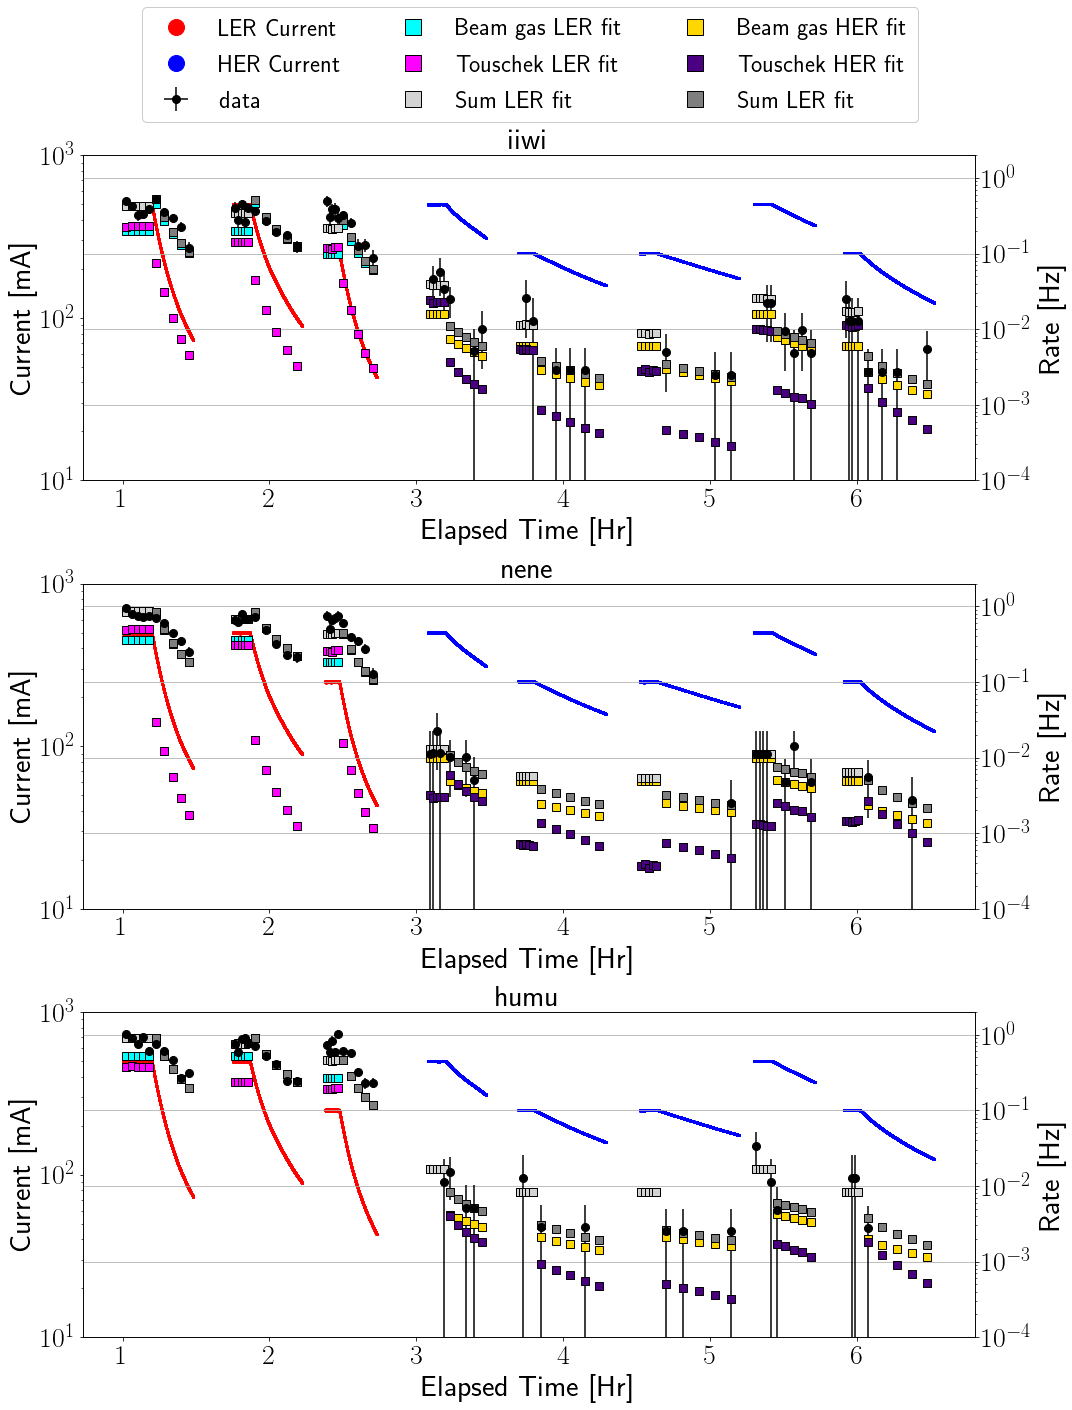

In [29]:
plt.rc('legend', fontsize=24)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', labelsize=30)
plt.rc('axes', titlesize=30)
plt.figure(figsize = (15,18))
i = 1
for tpc in ['iiwi', 'nene', 'humu']:
    plt.subplot(3,1,i)
    plt.plot(data.loc[(data['LER_study_flag']==1) & (data['Cont_inj_flag']==1)]['ts'], data.loc[(data['LER_study_flag']==1) & (data['Cont_inj_flag']==1)]['I_LER'], 'o', color = 'red',markersize = 2)
    plt.plot(data.loc[(data['LER_study_flag']==1) & (data['Decay_flag']==1)]['ts'], data.loc[(data['LER_study_flag']==1) & (data['Decay_flag']==1)]['I_LER'], 'o', color = 'red',markersize = 2)
    plt.plot(data.loc[(data['HER_study_flag']==1) & (data['Cont_inj_flag']==1)]['ts'], data.loc[(data['HER_study_flag']==1) & (data['Cont_inj_flag']==1)]['I_HER'], 'o', color = 'blue',markersize = 2)
    plt.plot(data.loc[(data['HER_study_flag']==1) & (data['Decay_flag']==1)]['ts'], data.loc[(data['HER_study_flag']==1) & (data['Decay_flag']==1)]['I_HER'], 'o', color = 'blue',markersize = 2)
    plt.ylim(10,1000)
    plt.ylabel("Current [mA]")
    plt.xlabel('Elapsed Time [Hr]')
    plt.yscale("Log")
    plt.title("%s"%(tpc))
    plt.twinx()
    plt.grid()
    #if i%2 != 1:
    #    plt.ylim(0,1.5)
    #else:
    #    if i != 5:
    #        plt.ylim(0,0.2)
    #    else:
    #        plt.ylim(0,0.4)
    plt.yscale("Log")
    plt.ylim(1e-4,2)
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_bg['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'cyan', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_bg['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'gold', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_bg['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'cyan', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_bg['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'gold', label = 'Predicted beam-gas rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_t['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'magenta', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit_t['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'indigo', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_t['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'magenta', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit_t['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'indigo', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit['%s_Cont_inj_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'lightgray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], fit['%s_Cont_inj_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)].index.to_numpy()], 's', color = 'lightgray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit['%s_Decay_LER'%(tpc)][data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'tab:gray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    plt.plot(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], fit['%s_Decay_HER'%(tpc)][data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)].index.to_numpy()], 's', color = 'tab:gray', label = 'Predicted Touschek rate', markersize = 8, markeredgecolor = 'black')
    p = plt.errorbar(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Cont_inj_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['LER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.errorbar(data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)][tpc+'_neutrons_err'], data_avg.loc[(data_avg['HER_study_flag']==1) & (data_avg['Decay_flag']==1)]['ts_err'], 'o', markersize = 8, color = 'black', label = 'data')
    plt.ylabel("Rate [Hz]")
    custom_lines = [Line2D([0], [0], color='red', label='LER Current', marker='o', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='blue', label='HER Current', marker='o', linewidth = 0, markersize = 16),
                    p,
                Line2D([0], [0], color='cyan', label='Beam gas LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='magenta', label='Touschek LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='lightgray', label='Sum LER fit', marker='s',markeredgecolor = 'black', linewidth = 0, markersize = 16),
                Line2D([0], [0], color='gold', label='Beam gas HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16),
                   Line2D([0], [0], color='indigo', label='Touschek HER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16),
                    Line2D([0], [0], color='tab:gray', label='Sum LER fit', marker='s', markeredgecolor = 'black',linewidth = 0, markersize = 16)
                   ]
    i += 1
plt.tight_layout()
plt.legend(handles=custom_lines, loc='lower right', framealpha = 1, ncol = 3, bbox_to_anchor=(0.95, 3.7))
plt.savefig("fit_comparison_fwd.png", bbox_inches='tight')